## ANOVA One-Way Tests and Permutation Tests

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

#### Data Preparation

In [2]:
# task dictionary
task_dict = {
    'stroop_vanilla': 'task-td7i',
    'stroop_progressbar': 'task-lupf',
    'stroop_eyes': 'task-c9op',
#     'stroop_video': 'task-najf',
    'stroop_posneg': 'task-on6n',
    'stroop_final': 'task-7g42',
    'stroop_bonus': 'task-3kpz',
    'rdk_vanilla': 'task-2ywa',
    'rdk_progressbar': 'task-sks3',
    'rdk_eyes': 'task-zyvq',
#     'rdk_video': 'task-6e3k',
    'rdk_posneg': 'task-ivrk',
    'rdk_final': 'task-sq3v',
    'rdk_bonus': 'task-hvii',
    'bandit_vanilla': 'task-dwkr',
    'bandit_progressbar': 'task-25bt',
    'bandit_eyes': 'task-x158',
#     'bandit_video': 'task-9ndm',
    'bandit_posneg': 'task-tzk1',
    'bandit_final': 'task-gn7s',
    'bandit_bonus': 'task-iaas',
}

# task-separated arrays
# stroop_arr = ["stroop_vanilla", "stroop_progressbar", "stroop_eyes", "stroop_video", "stroop_posneg", "stroop_final", "stroop_bonus"]
# rdk_arr = ["rdk_vanilla", "rdk_progressbar", "rdk_eyes", "rdk_video", "rdk_posneg", "rdk_final", "rdk_bonus"]
# bandit_arr = ["bandit_vanilla", "bandit_progressbar", "bandit_eyes", "bandit_video", "bandit_posneg", "bandit_final", "bandit_bonus"]
stroop_arr = ["stroop_vanilla", "stroop_progressbar", "stroop_eyes", "stroop_posneg", "stroop_final", "stroop_bonus"]
rdk_arr = ["rdk_vanilla", "rdk_progressbar", "rdk_eyes", "rdk_posneg", "rdk_final", "rdk_bonus"]
bandit_arr = ["bandit_vanilla", "bandit_progressbar", "bandit_eyes", "bandit_posneg", "bandit_final", "bandit_bonus"]

In [3]:
stroop_list = []

for manip in stroop_arr:
    stroop_df = pd.read_csv('./data_exp_99963-v4/data_exp_99963-v4_' + task_dict[manip] + '.csv')
    stroop_df.drop(stroop_df[stroop_df['Event Index'] == 'END OF FILE'].index, inplace = True)
    stroop_list.append(stroop_df)
    
# for manip in stroop_arr:
#     stroop_df = pd.read_csv('./data_exp_96489-v3/data_exp_96489-v3_' + task_dict[manip] + '.csv')
#     stroop_df.drop(stroop_df[stroop_df['Event Index'] == 'END OF FILE'].index, inplace = True)
#     stroop_list.append(stroop_df)
    
stroop_df = pd.concat(stroop_list)
stroop_df = stroop_df[[
    "Tree Node Key",
    "Participant Private ID",
    "Screen Name",
    "Attempt",
    "Correct",
    "Incorrect"
]]

rdk_list = []

for manip in rdk_arr:
    rdk_df = pd.read_csv('./data_exp_99963-v4/data_exp_99963-v4_' + task_dict[manip] + '.csv')
    rdk_df.drop(rdk_df[rdk_df['Event Index'] == 'END OF FILE'].index, inplace = True)
    rdk_list.append(rdk_df)
    
# for manip in rdk_arr:
#     rdk_df = pd.read_csv('./data_exp_96489-v3/data_exp_96489-v3_' + task_dict[manip] + '.csv')
#     rdk_df.drop(rdk_df[rdk_df['Event Index'] == 'END OF FILE'].index, inplace = True)
#     rdk_list.append(rdk_df)
    
rdk_df = pd.concat(rdk_list)
rdk_df = rdk_df[[
    "Tree Node Key",
    "Participant Private ID",
    "Screen Name",
    "Attempt",
    "Correct",
    "Incorrect"
]]


bandit_list = []

for manip in bandit_arr:
    bandit_df = pd.read_csv('./data_exp_99963-v4/data_exp_99963-v4_' + task_dict[manip] + '.csv')
    bandit_df.drop(bandit_df[bandit_df['Event Index'] == 'END OF FILE'].index, inplace = True)
    bandit_list.append(bandit_df)
    
# for manip in bandit_arr:
#     bandit_df = pd.read_csv('./data_exp_96489-v3/data_exp_96489-v3_' + task_dict[manip] + '.csv')
#     bandit_df.drop(bandit_df[bandit_df['Event Index'] == 'END OF FILE'].index, inplace = True)
#     bandit_list.append(bandit_df)
    
bandit_df = pd.concat(bandit_list)
bandit_df = bandit_df[[
    "Tree Node Key",
    "Participant Private ID",
    "Screen Name",
    "Attempt",
    "Correct",
    "Incorrect"
]]

C:\Users\Devank\AppData\Local\Temp/ipykernel_24036/2369746899.py:4: DtypeWarning: Columns (0,58) have mixed types. Specify dtype option on import or set low_memory=False.
  stroop_df = pd.read_csv('./data_exp_99963-v4/data_exp_99963-v4_' + task_dict[manip] + '.csv')
C:\Users\Devank\AppData\Local\Temp/ipykernel_24036/2369746899.py:26: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  rdk_df = pd.read_csv('./data_exp_99963-v4/data_exp_99963-v4_' + task_dict[manip] + '.csv')
C:\Users\Devank\AppData\Local\Temp/ipykernel_24036/2369746899.py:49: DtypeWarning: Columns (0,58) have mixed types. Specify dtype option on import or set low_memory=False.
  bandit_df = pd.read_csv('./data_exp_99963-v4/data_exp_99963-v4_' + task_dict[manip] + '.csv')


In [4]:
def accuracy_df_builder(df, arr, task):
    
    performance_df = pd.DataFrame(columns=['Participant', 'Task', 'Manipulation', 'Accuracy'])
    for manip in arr:

        focus_df = df[df['Tree Node Key'] == task_dict[manip]]
        participants = focus_df['Participant Private ID'].unique().tolist()
        if len(participants) < 1:
            accuracies.append(overall_accuracy)
            continue
        
        for participant in participants:
            participant_df = focus_df[focus_df['Participant Private ID'] == participant]
            participant_df = participant_df[participant_df['Screen Name'] == 'trial'][['Attempt', 'Correct', 'Incorrect']]

            if participant_df.empty:
                participants.remove(participant)
                continue

            # for timeouts
            participant_df['Attempt'].fillna(0, inplace = True)
            
            accuracy = participant_df['Correct'].sum() * 100 / len(participant_df)
            performance_df = performance_df.append({
                'Participant': participant,
                'Task': task,
                'Manipulation': manip,
                'Accuracy': accuracy
            }, ignore_index=True)
            
    return performance_df

In [5]:
def sample_equal_rows(df, column, count):
    
    new_df = pd.DataFrame(columns=df.columns)
    for value in df[column].unique():
        new_df = new_df.append(df[df[column] == value].sample(count))
    return new_df

In [33]:
stroop_acc_df = accuracy_df_builder(stroop_df, stroop_arr, "Stroop")
rdk_acc_df = accuracy_df_builder(rdk_df, rdk_arr, "RDK")
bandit_acc_df = accuracy_df_builder(bandit_df, bandit_arr, "Bandit")

performance_df = pd.concat([stroop_acc_df, rdk_acc_df, bandit_acc_df])
performance_df.reset_index(inplace=True)
performance_df = performance_df.drop(performance_df[performance_df["Task"] == "Stroop"].index)

#### I. Comparing different tasks across manipulations

$H_0$: The mean performance of participants is statisitically similar for all three tasks (Stroop, RDK, bandit).

$H_a$: The mean performance of participants is significantly dissimilar for different tasks.

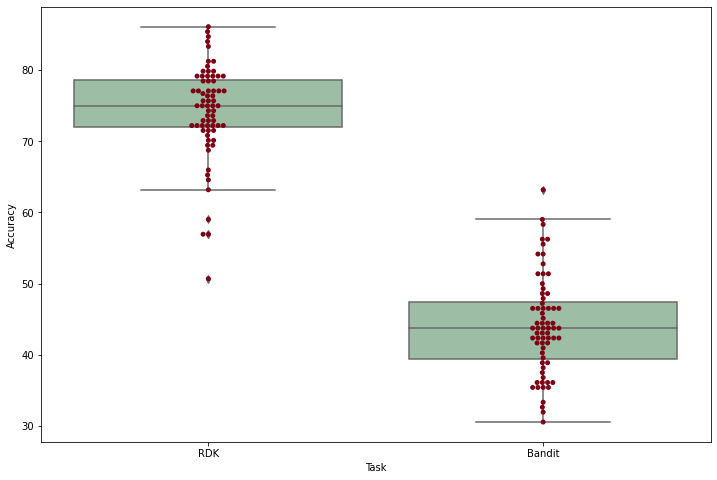

In [34]:
task_min_count = min(performance_df["Task"].value_counts())
task_performance_df = sample_equal_rows(performance_df, "Task", task_min_count)

fig = plt.figure(figsize=(12,8))
ax = sns.boxplot(x='Task', y='Accuracy', data=task_performance_df, color='#99c2a2')
ax = sns.swarmplot(x="Task", y="Accuracy", data=task_performance_df, color='#7d0013')
plt.show()

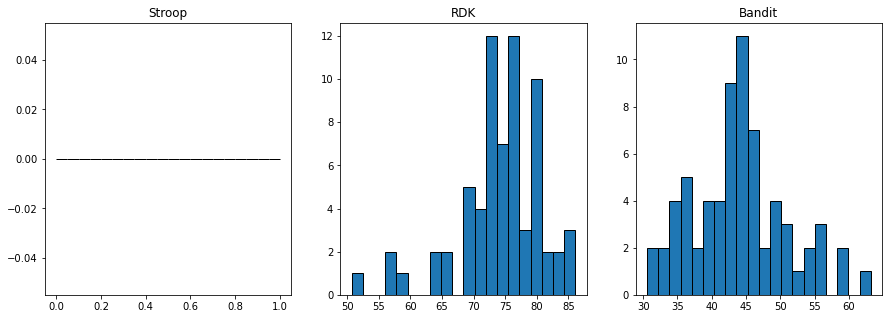

In [35]:
# fig = sm.qqplot(task_performance_df[task_performance_df["Task"] == "Stroop"]["Accuracy"], line='45')
fig = plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.hist(task_performance_df[task_performance_df["Task"] == "Stroop"]["Accuracy"], edgecolor='black', bins=20)
plt.title("Stroop")
plt.subplot(1,3,2)
plt.hist(task_performance_df[task_performance_df["Task"] == "RDK"]["Accuracy"], edgecolor='black', bins=20)
plt.title("RDK")
plt.subplot(1,3,3)
plt.hist(task_performance_df[task_performance_df["Task"] == "Bandit"]["Accuracy"], edgecolor='black', bins=20)
plt.title("Bandit")
plt.show()

In [36]:
model1 = ols('Accuracy ~ Task', data=task_performance_df).fit()
# test for normality - FAILED
print(stats.shapiro(model1.resid))


ShapiroResult(statistic=0.9836644530296326, pvalue=0.10389432311058044)


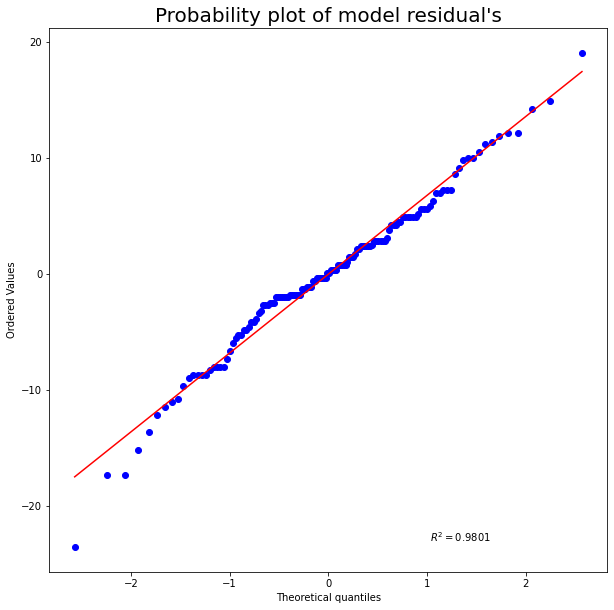

In [37]:
# another test for normality

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model1.resid, plot=plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

In [38]:
anova_table = sm.stats.anova_lm(model1, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
Task,30805.881671,1.0,664.483382,8.730398e-54
Residual,6212.327134,134.0,NaN,NaN


###### How to interpret these results?

#### II. Comparing different manipulations across tasks

$H_0$: The mean performance of participants is statisitically similar for all seven manipulations.

$H_a$: The mean performance of participants is significantly dissimilar for different manipulations.

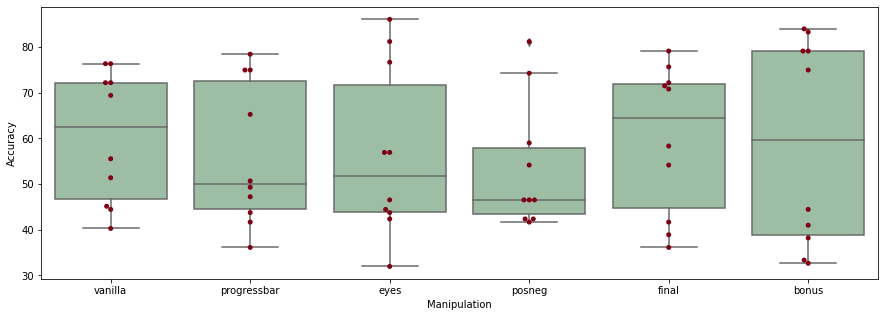

In [12]:
manip_performance_df = performance_df
manip_performance_df = manip_performance_df.replace('rdk_', '', regex=True)
manip_performance_df = manip_performance_df.replace('stroop_', '', regex=True)
manip_performance_df = manip_performance_df.replace('bandit_', '', regex=True)

manip_min_count = min(manip_performance_df["Manipulation"].value_counts())
manip_performance_df = sample_equal_rows(manip_performance_df, "Manipulation", manip_min_count)

fig = plt.figure(figsize=(15,5))
ax = sns.boxplot(x='Manipulation', y='Accuracy', data=manip_performance_df, color='#99c2a2')
ax = sns.swarmplot(x="Manipulation", y="Accuracy", data=manip_performance_df, color='#7d0013')
plt.show()

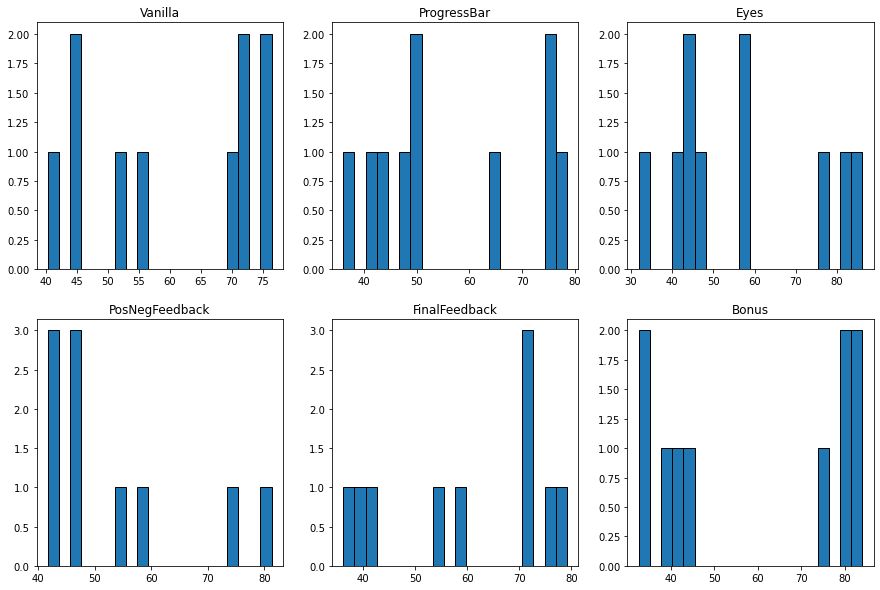

In [13]:
fig = plt.figure(figsize=(15, 10))
plt.subplot(2,3,1)
plt.hist(manip_performance_df[manip_performance_df["Manipulation"] == "vanilla"]["Accuracy"], edgecolor='black', bins=20)
plt.title("Vanilla")
plt.subplot(2,3,2)
plt.hist(manip_performance_df[manip_performance_df["Manipulation"] == "progressbar"]["Accuracy"], edgecolor='black', bins=20)
plt.title("ProgressBar")
plt.subplot(2,3,3)
plt.hist(manip_performance_df[manip_performance_df["Manipulation"] == "eyes"]["Accuracy"], edgecolor='black', bins=20)
plt.title("Eyes")
plt.subplot(2,3,4)
plt.hist(manip_performance_df[manip_performance_df["Manipulation"] == "posneg"]["Accuracy"], edgecolor='black', bins=20)
plt.title("PosNegFeedback")
plt.subplot(2,3,5)
plt.hist(manip_performance_df[manip_performance_df["Manipulation"] == "final"]["Accuracy"], edgecolor='black', bins=20)
plt.title("FinalFeedback")
plt.subplot(2,3,6)
plt.hist(manip_performance_df[manip_performance_df["Manipulation"] == "bonus"]["Accuracy"], edgecolor='black', bins=20)
plt.title("Bonus")
plt.show()

In [14]:
model2 = ols('Accuracy ~ Manipulation', data=manip_performance_df).fit()
print(stats.shapiro(model2.resid))

ShapiroResult(statistic=0.9318960309028625, pvalue=0.002392195863649249)


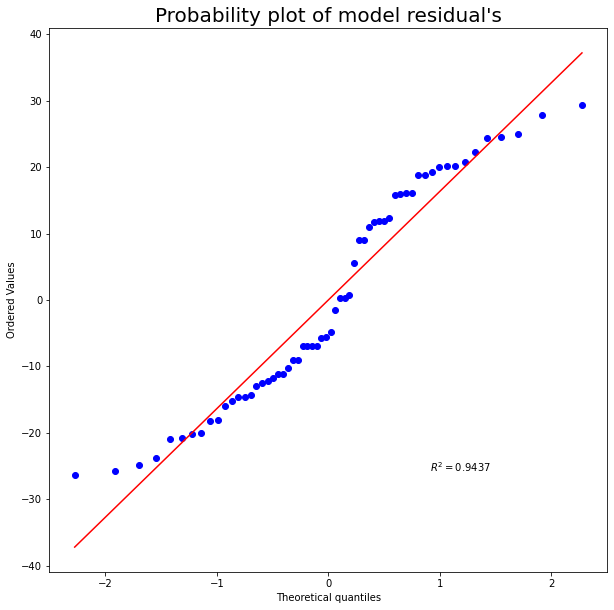

In [15]:
# another test for normality

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model2.resid, plot=plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

In [16]:
anova_table = sm.stats.anova_lm(model2, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
Manipulation,343.706859,5.0,0.232395,0.946669
Residual,15972.969728,54.0,NaN,NaN


## Permutation Tests

Let's see how this goes.

In [17]:
def statistic(x, y, axis):
    return (np.mean(x, axis=axis) - np.mean(y, axis=axis))[0]

In [18]:
# comparing between two tasks

x = np.asarray(performance_df[performance_df["Task"] == "Stroop"][["Accuracy"]])
y = np.asarray(performance_df[performance_df["Task"] == "RDK"][["Accuracy"]])
z = np.asarray(performance_df[performance_df["Task"] == "Bandit"][["Accuracy"]])

print(statistic(x, y, 0))
print(statistic(y, z, 0))
print(statistic(z, x, 0))


19.965627518130532
30.002130418377405
-49.96775793650794


In [19]:
res = stats.permutation_test((x, y), statistic, vectorized=True, n_resamples=1e6, alternative='less')
print(res.statistic)
print(res.pvalue)

19.965627518130532
1.999998000002e-06


In [20]:
res = stats.permutation_test((y, z), statistic, vectorized=True, n_resamples=1e6, alternative='less')
print(res.statistic)
print(res.pvalue)

30.002130418377405
1.999998000002e-06


In [21]:
res = stats.permutation_test((x, z), statistic, vectorized=True, n_resamples=1e6, alternative='less')
print(res.statistic)
print(res.pvalue)

49.96775793650794
1.999998000002e-06


All these permutation tests reject the null hypotheses. Therefore, we can say that the main effect of tasks is pairwise significant.

#### Permutation tests for manipulations

In [22]:
manip_1 = performance_df[performance_df["Manipulation"].str.contains("vanilla")]
manip_2 = performance_df[performance_df["Manipulation"].str.contains("progress")]
manip_3 = performance_df[performance_df["Manipulation"].str.contains("eyes")]
manip_4 = performance_df[performance_df["Manipulation"].str.contains("posneg")]
manip_5 = performance_df[performance_df["Manipulation"].str.contains("final")]
manip_6 = performance_df[performance_df["Manipulation"].str.contains("bonus")]

##### Stroop

In [23]:
str_manip_1 = manip_1[manip_1["Task"] == "Stroop"][["Accuracy"]]
str_manip_2 = manip_2[manip_2["Task"] == "Stroop"][["Accuracy"]]
str_manip_3 = manip_3[manip_3["Task"] == "Stroop"][["Accuracy"]]
str_manip_4 = manip_4[manip_4["Task"] == "Stroop"][["Accuracy"]]
str_manip_5 = manip_5[manip_5["Task"] == "Stroop"][["Accuracy"]]
str_manip_6 = manip_6[manip_6["Task"] == "Stroop"][["Accuracy"]]

print(len(str_manip_4))

49


In [24]:
# vanilla vs progress-bar
res = stats.permutation_test((str_manip_1, str_manip_2), statistic, vectorized=True, n_resamples=np.inf)
print(res.statistic)
print(res.pvalue)

4.453125000000014
0.015873015873015872


In [25]:
# vanilla vs eyes
res = stats.permutation_test((str_manip_1, str_manip_3), statistic, vectorized=True, n_resamples=np.inf)
print(res.statistic)
print(res.pvalue)

-2.604166666666657
0.02857142857142857


In [26]:
# vanilla vs posneg
res = stats.permutation_test((str_manip_1, str_manip_4), statistic, vectorized=True, n_resamples=np.inf)
print(res.statistic)
print(res.pvalue)

-2.5111607142857224
6.830017928797063e-06


In [27]:
# vanilla vs final
res = stats.permutation_test((str_manip_1, str_manip_5), statistic, vectorized=True, n_resamples=np.inf)
print(res.statistic)
print(res.pvalue)

-1.6927083333333144
0.015873015873015872


In [28]:
# vanilla vs bonus
res = stats.permutation_test((str_manip_1, str_manip_6), statistic, vectorized=True, n_resamples=np.inf)
print(res.statistic)
print(res.pvalue)

15.807291666666657
0.015873015873015872


In [29]:
# progress-bar vs eyes
res = stats.permutation_test((str_manip_2, str_manip_3), statistic, vectorized=True, n_resamples=np.inf)
print(res.statistic)
print(res.pvalue)

-7.057291666666671
0.015873015873015872


In [30]:
# progress-bar vs posneg
res = stats.permutation_test((str_manip_2, str_manip_4), statistic, vectorized=True, n_resamples=np.inf)
print(res.statistic)
print(res.pvalue)

KeyboardInterrupt: 

In [ ]:
# progress-bar vs final
res = stats.permutation_test((str_manip_2, str_manip_5), statistic, vectorized=True, n_resamples=np.inf)
print(res.statistic)
print(res.pvalue)

In [ ]:
# progress-bar vs bonus
res = stats.permutation_test((str_manip_2, str_manip_6), statistic, vectorized=True, n_resamples=np.inf)
print(res.statistic)
print(res.pvalue)

In [ ]:
# eyes vs posneg
res = stats.permutation_test((str_manip_3, str_manip_4), statistic, vectorized=True, n_resamples=np.inf, alternative='less')
print(res.statistic)
print(res.pvalue)

In [ ]:
# eyes vs final
res = stats.permutation_test((str_manip_3, str_manip_5), statistic, vectorized=True, n_resamples=np.inf)
print(res.statistic)
print(res.pvalue)

In [ ]:
# eyes vs bonus
res = stats.permutation_test((str_manip_3, str_manip_6), statistic, vectorized=True, n_resamples=np.inf)
print(res.statistic)
print(res.pvalue)

In [ ]:
# posneg vs final
res = stats.permutation_test((str_manip_4, str_manip_5), statistic, vectorized=True, n_resamples=np.inf)
print(res.statistic)
print(res.pvalue)

In [ ]:
# posneg vs bonus
res = stats.permutation_test((str_manip_4, str_manip_6), statistic, vectorized=True, n_resamples=np.inf)
print(res.statistic)
print(res.pvalue)

In [ ]:
# final vs bonus
res = stats.permutation_test((str_manip_5, str_manip_6), statistic, vectorized=True, n_resamples=np.inf)
print(res.statistic)
print(res.pvalue)

### WITHIN TASK ANOVAs

#### I. Stroop

In [ ]:
stroop_performance_df = performance_df[performance_df["Task"] == "Stroop"]
stroop_performance_df = sample_equal_rows(stroop_performance_df, "Manipulation", min(stroop_performance_df["Manipulation"].value_counts()))

fig = plt.figure(figsize=(15,5))
ax = sns.boxplot(x='Manipulation', y='Accuracy', data=stroop_performance_df, color='#99c2a2')
ax = sns.swarmplot(x="Manipulation", y="Accuracy", data=stroop_performance_df, color='#7d0013')
plt.show()

In [ ]:
model3 = ols('Accuracy ~ Manipulation', data=stroop_performance_df).fit()
print(stats.shapiro(model3.resid))

In [ ]:
# another test for normality

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model3.resid, plot=plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

In [ ]:
anova_table = sm.stats.anova_lm(model3, typ=2)
anova_table

#### II. RDK

In [ ]:
rdk_performance_df = performance_df[performance_df["Task"] == "RDK"]
rdk_performance_df = sample_equal_rows(rdk_performance_df, "Manipulation", min(rdk_performance_df["Manipulation"].value_counts()))

fig = plt.figure(figsize=(15,5))
ax = sns.boxplot(x='Manipulation', y='Accuracy', data=rdk_performance_df, color='#99c2a2')
ax = sns.swarmplot(x="Manipulation", y="Accuracy", data=rdk_performance_df, color='#7d0013')
plt.show()

In [ ]:
model4 = ols('Accuracy ~ Manipulation', data=rdk_performance_df).fit()
print(stats.shapiro(model4.resid))

In [ ]:
# another test for normality

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model4.resid, plot=plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

In [ ]:
anova_table = sm.stats.anova_lm(model4, typ=2)
anova_table

#### II. RDK

In [ ]:
bandit_performance_df = performance_df[performance_df["Task"] == "Bandit"]
bandit_performance_df = sample_equal_rows(bandit_performance_df, "Manipulation", min(bandit_performance_df["Manipulation"].value_counts()))

fig = plt.figure(figsize=(15,5))
ax = sns.boxplot(x='Manipulation', y='Accuracy', data=bandit_performance_df, color='#99c2a2')
ax = sns.swarmplot(x="Manipulation", y="Accuracy", data=bandit_performance_df, color='#7d0013')
plt.show()

In [ ]:
model5 = ols('Accuracy ~ Manipulation', data=rdk_performance_df).fit()
print(stats.shapiro(model5.resid))

In [ ]:
# another test for normality

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model5.resid, plot=plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

In [ ]:
anova_table = sm.stats.anova_lm(model5, typ=2)
anova_table